In [57]:
import os
import glob
import random
import pytorch_lightning as pt
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split

### Define Transforms

In [24]:
train_transformations = transforms.Compose([
    transforms.ToTensor()
])

validation_transformations = transforms.Compose([
    transforms.ToTensor()
])

### Create train, validation sets

In [35]:
benign_path = "features/images/benign/gaf/branch_instructions"
ransomware_path = "features/images/ransomware/gaf/branch_instructions"

train_valid_image_paths = list()
classes = list()

for path in glob.glob(os.path.join(benign_path, "*")):
    classes.append(path.split("/")[2])
    train_valid_image_paths.append(path)

for path in glob.glob(os.path.join(ransomware_path, "*")):
    classes.append(path.split("/")[2])
    train_valid_image_paths.append(path)

classes = list(set(classes))
random.shuffle(train_valid_image_paths)

print(f"Path example: {train_valid_image_paths[0]}")
print(f"Class example: {classes[0]}")

Path example: features/images/ransomware/gaf/branch_instructions/ransomware_1.jpg
Class example: benign


In [40]:
train_image_paths, valid_image_paths = train_test_split(train_valid_image_paths, train_size=0.7)

print(f"Train size: {len(train_image_paths)}")
print(f"Valid size {len(valid_image_paths)}")

Train size: 280
Valid size 120


In [42]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

idx_to_class

{0: 'benign', 1: 'ransomware'}

### Dataset class

In [50]:
class RansomwareDetectionDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        super().__init__()

        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = skimage.io.imread(image_path)

        label = image_path.split("/")[2]
        label = class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

### Create datasets

In [54]:
train_dataset = RansomwareDetectionDataset(train_image_paths, train_transformations)
validation_dataset = RansomwareDetectionDataset(valid_image_paths, validation_transformations)

print(f"Tensor shape of the image: {train_dataset[1][0].shape}")
print(f"Label of the image: {idx_to_class[train_dataset[1][1]]}")

Tensor shape of the image: torch.Size([3, 50, 50])
Label of the image: ransomware


### Create Dataloaders

In [61]:
BATCH_SIZE = 5

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Train dataloader shape {next(iter(train_dataloader))[0].shape}")
print(f"Validation dataloader shape {next(iter(validation_dataloader))[0].shape}")

Train dataloader shape torch.Size([5, 3, 50, 50])
Validation dataloader shape torch.Size([5, 3, 50, 50])


[tensor([[[[0.3922, 0.1647, 0.3451,  ..., 0.1804, 0.3255, 0.3373],
          [0.1686, 0.0000, 0.1294,  ..., 0.0000, 0.0431, 0.0510],
          [0.3451, 0.1176, 0.3059,  ..., 0.1725, 0.1725, 0.1804],
          ...,
          [0.1843, 0.0000, 0.1686,  ..., 0.1216, 0.1373, 0.1451],
          [0.3176, 0.0431, 0.1686,  ..., 0.1333, 0.2275, 0.2353],
          [0.3373, 0.0588, 0.1843,  ..., 0.1490, 0.2431, 0.2549]],

         [[0.4392, 0.2392, 0.4784,  ..., 0.4784, 0.3373, 0.3490],
          [0.2431, 0.0353, 0.2824,  ..., 0.2667, 0.1569, 0.1647],
          [0.4784, 0.2784, 0.5255,  ..., 0.4824, 0.4118, 0.4196],
          ...,
          [0.4824, 0.2549, 0.4784,  ..., 0.4784, 0.3804, 0.3882],
          [0.3294, 0.1569, 0.4078,  ..., 0.3843, 0.2392, 0.2471],
          [0.3490, 0.1725, 0.4235,  ..., 0.4000, 0.2549, 0.2667]],

         [[0.8314, 0.5098, 0.6235,  ..., 0.4627, 0.5529, 0.5647],
          [0.5137, 0.1961, 0.3098,  ..., 0.3020, 0.3216, 0.3294],
          [0.6235, 0.3020, 0.4196,  ..., 

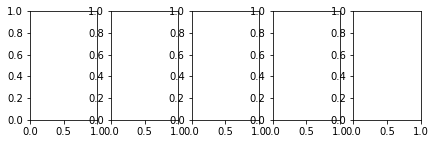

In [65]:
fig, ax = plt.subplots(1, 5, figsize=(7, 2))
for index, image in enumerate(train_dataloader):
    print(image)
    #ax[0, index].imshow(image[0])